# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [ ]:
import math

import numpy as np
import pandas as pd

import spacy
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn.metrics as metrics

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [ ]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

In [ ]:
# mostrar hasta 20 columnas
pd.options.display.max_columns = 20

## Cargar datos

In [ ]:
# Cargamos los datos
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [ ]:
# Visualizamos el DF
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [ ]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [ ]:
# Revisamos valores ausentes
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [ ]:
# Revisamos valores duplicados
df_reviews.duplicated().sum()

0

In [ ]:
# Revisamos nombres de las columnas
df_reviews.columns

Index(['tconst', 'title_type', 'primary_title', 'original_title', 'start_year',
       'end_year', 'runtime_minutes', 'is_adult', 'genres', 'average_rating',
       'votes', 'review', 'rating', 'sp', 'pos', 'ds_part', 'idx'],
      dtype='object')

Todo está en orden, solo hay 4 valores nulos cuyas filas descartaremos. Esto no afectará al resultado debido a que representan menos de 1% de los datos.

In [ ]:
# Descartamos valores nulos
df_reviews.dropna(inplace=True)

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

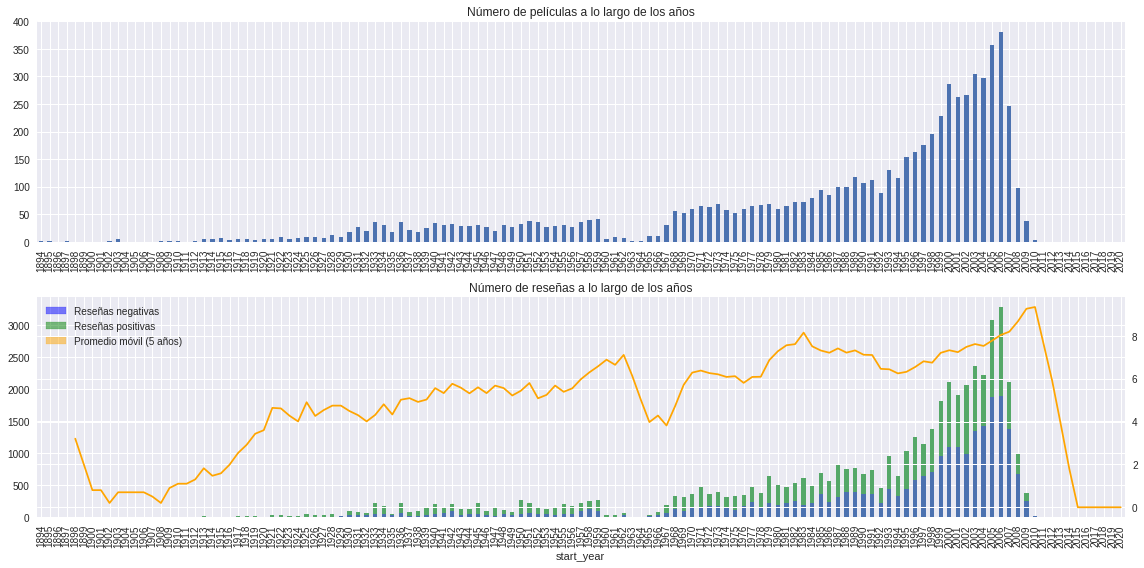

In [ ]:

fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)


ax.fill_between(dft2.index, dft2[0], color='blue', alpha=0.5, label='Reseñas negativas')

ax.fill_between(dft2.index, dft2[1], color='green', alpha=0.5, label='Reseñas positivas')

ax.fill_between([], [], color='orange', alpha=0.5, label='Promedio móvil (5 años)')

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')
ax.legend(['Reseñas negativas', 'Reseñas positivas', 'Promedio móvil (5 años)'])

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

- El primer gráfico nos indica como ha aumentado la producción de peliculas a través de los años.


- El segundo gráfico nos indica el aumento de reseñas a través del tiempo. Las barras azules representan reseñas negativas y las verdes positivas; se puede observar como han aumentado de forma más bien pareja. Asimismo, la línea amarilla representa el promedio movil por películas en un periodo de 5 años; en este caso nos muestra una tendencia en los datos.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

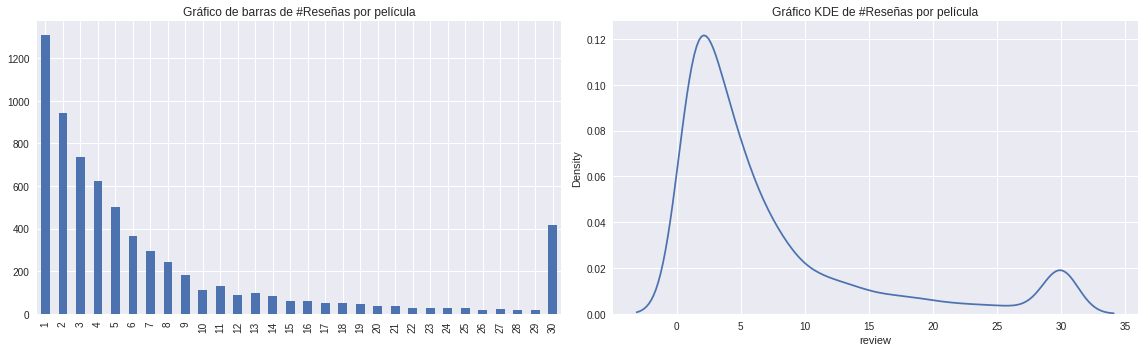

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

Como podemos observar: predominan las películas con un menos reviews. Es probable que esto ocurra en el caso de películas antiguas, en un contexto donde el mundo aún no estaba globalizado por medio de la tecnología y no existían muchos críticos de películas.

In [ ]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

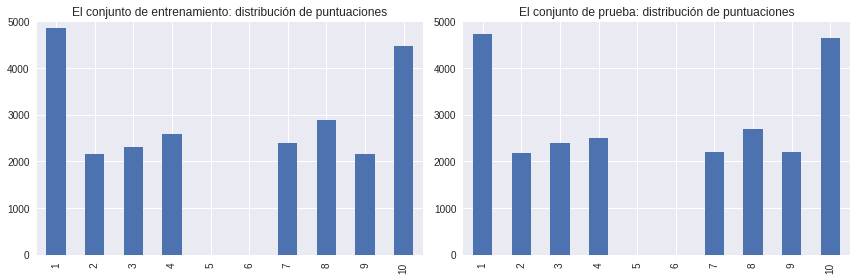

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

En este caso el desequilibrio de clases es bajo. Es decir, tenemos 23.715 valores negativos y 23.614 positivos. Por otra parte, esto se ve reflejado en la visualización del conjunto de entrenamiento y de prueba. Se ven bastante parejos.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


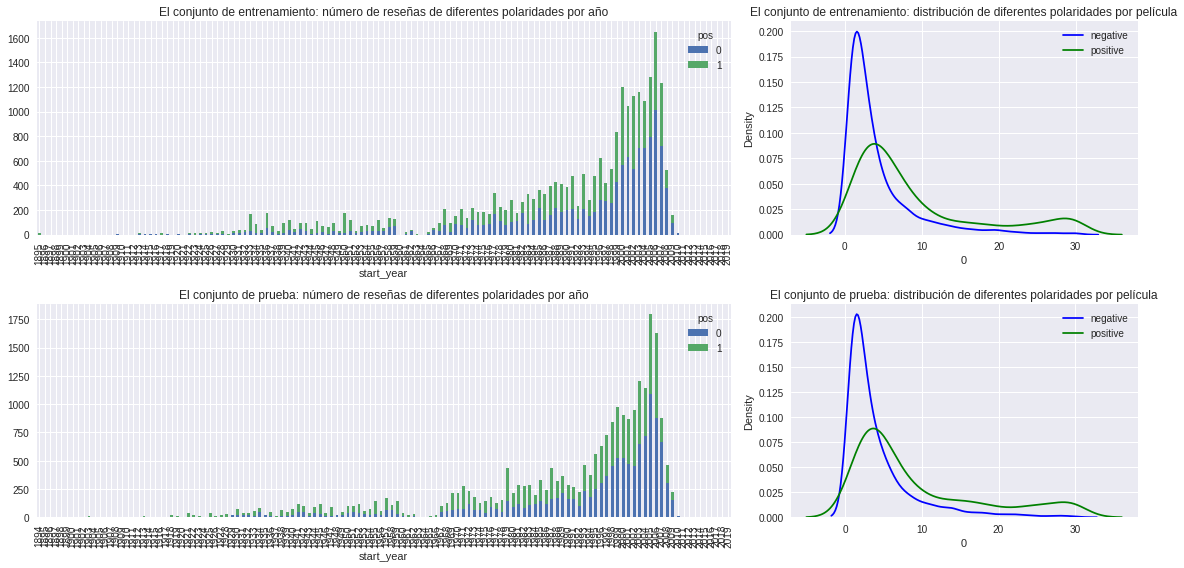

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

- En ambos conjuntos se ve un patrón muy similar. A medida que pasan los años la distribución de los reviews negativos y positivos se ven parejos.  
- Sobre el gráfico KDE, podemos ver que las peliculas con menos reviews tienden a ser negativas. Como mencionamos antes, esto debe deberse a películas antiguas o más modernas pero poco conocidas, como películas 'indies' y de menos recursos.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [ ]:
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [ ]:
# Función para normalizar y limpiar un texto
def clean_text(text):
    ## Pasar texto a minúsculas
    text = text.lower()

    ## Eliminar dígitos y caracteres especiales usando regex
    text = re.sub(r'[^a-z\s]', '', text)

    ## Eliminar espacios en blanco adicionales
    text = ' '.join(text.split())

    return text

In [ ]:
# Limpiamos los textos
df_reviews['review_norm'] = df_reviews['review'].apply(clean_text)

In [ ]:
# Revisamos los cambios
df_reviews.head(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,the pakage implies that warren beatty and gold...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,how the hell did they get this made presenting...
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489,there is no real story the film seems more lik...
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280,um a serious film about troubled teens in sing...
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281,im totally agree with garryjohal from singapor...


## División entrenamiento / prueba

A continuación dividimos la tabla en el conjunto de entrenamiento y el conjunto de prueba.

In [ ]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Preprocesamiento para modelos

En los siguientes pasos crearemos dos conjuntos. Uno vectorizado y otro vectorizado y *lemmatizado*. Esto con el fin de hacer pruebas con distintos conjuntos y así comparar las diferencias de sus rendimientos.

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
def lemmatize(text):

    doc = nlp(text.lower())

    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
    return ' '.join(lemmas)

In [ ]:
stop_words = set(stopwords.words('english'))

En este caso aplicare TfidVectorizer con max_features=50000, para limitar el número de columnas, de otro modo se generarán 105373 y resultará una operación demasiado costosa.

In [ ]:
# Vectorizamos el texto

train_corpus = df_reviews_train['review_norm']
test_corpus = df_reviews_test['review_norm']

max_features= 50000
tf_idf = TfidfVectorizer(stop_words="english", lowercase=True, max_features = max_features)
train_tf_idf = tf_idf.fit_transform(train_corpus)
test_tf_idf = tf_idf.transform(test_corpus)

In [ ]:
print(train_tf_idf.shape)

(23796, 50000)


In [ ]:
%%time
# Aplicamos el lemmatizer

df_reviews_train["lemmatized_text"] = df_reviews_train["review_norm"].apply(lemmatize)
df_reviews_test["lemmatized_text"] = df_reviews_test["review_norm"].apply(lemmatize)

CPU times: user 17min 23s, sys: 1.48 s, total: 17min 25s
Wall time: 17min 25s


In [ ]:
lem_train_corpus = df_reviews_train["lemmatized_text"]
lem_test_corpus = df_reviews_test["lemmatized_text"]

max_features= 50000
lem_tf_idf = TfidfVectorizer(stop_words="english", lowercase=True, max_features = max_features)
lem_train_tf_idf = lem_tf_idf.fit_transform(lem_train_corpus)
lem_test_tf_idf = lem_tf_idf.transform(lem_test_corpus)

In [ ]:
print(lem_train_tf_idf.shape)

(23796, 50000)


## Trabajar con modelos

Entrenaremos nuestros dos conjuntos de datos con los modelos LogisticRegression, LGMBClassifier y SVC.

Comenzaremos con el conjunto vectorizado.

In [ ]:
random_state = 200

In [ ]:
%%time
lr_model = LogisticRegression(random_state=random_state, max_iter=100)
lgbm_model = LGBMClassifier(learning_rate=0.1, random_state=random_state)
svc_model = SVC(gamma='auto', probability=True, random_state=random_state)

lr_model.fit(train_tf_idf, train_target)
lgbm_model.fit(train_tf_idf, train_target)
svc_model.fit(train_tf_idf, train_target)

CPU times: user 49min 41s, sys: 7.45 s, total: 49min 49s
Wall time: 49min 50s


SVC(gamma='auto', probability=True, random_state=200)

Seguimos con el conjunto lematizado.

In [ ]:
%%time
lem_lr_model = LogisticRegression(random_state=random_state, max_iter=100)
lem_lgbm_model = LGBMClassifier(learning_rate=0.1, random_state=random_state)
lem_svc_model = SVC(gamma='auto', probability=True, random_state=random_state)

lem_lr_model.fit(lem_train_tf_idf, train_target)
lem_lgbm_model.fit(lem_train_tf_idf, train_target)
lem_svc_model.fit(lem_train_tf_idf, train_target)

CPU times: user 46min 5s, sys: 5.66 s, total: 46min 10s
Wall time: 46min 11s


SVC(gamma='auto', probability=True, random_state=200)

En ambos casos ambos modelos tardaron bastante! Esto se debe a que TfidfVectorizer genera bastantes dimensiones.

## Evaluación de modelos

In [ ]:
models = {
    "logistic regression": lr_model,
    "lgbm": lgbm_model,
    "svc": svc_model,
    "lem_logistic": lem_lr_model,
    "lem_lgbm": lem_lgbm_model,
    "lem_svc": lem_svc_model,
}

In [ ]:
# Modelos en el conjunto original
original_models = {
    "logistic regression": lr_model,
    "lgbm": lgbm_model,
    "svc": svc_model,
}

# Modelos en el conjunto lematizado
lemmatized_models = {
    "lem_logistic": lem_lr_model,
    "lem_lgbm": lem_lgbm_model,
    "lem_svc": lem_svc_model,
}

In [ ]:
# Conjuntos de datos
original_train_set = (train_tf_idf, test_tf_idf)
lemmatized_train_set = (lem_train_tf_idf, lem_test_tf_idf)


Evaluando logistic regression en el conjunto de datos original:
          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


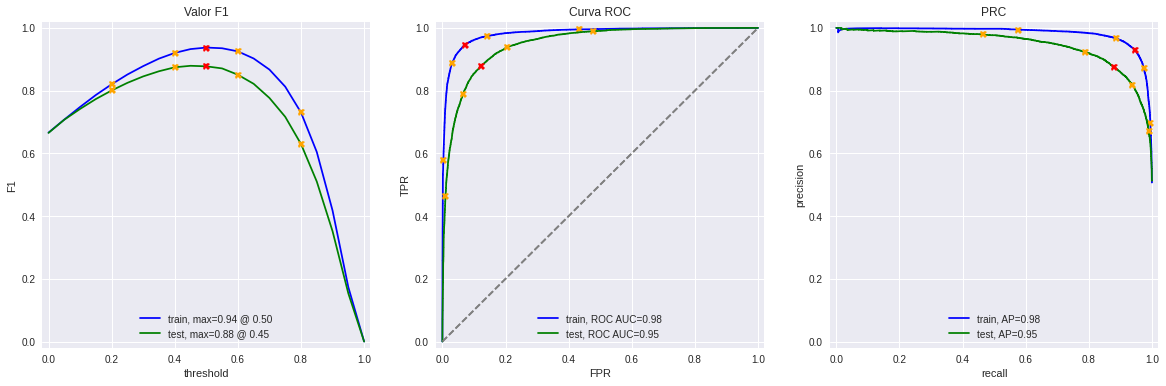

Evaluando lgbm en el conjunto de datos original:
          train  test
Accuracy   0.91  0.85
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.93


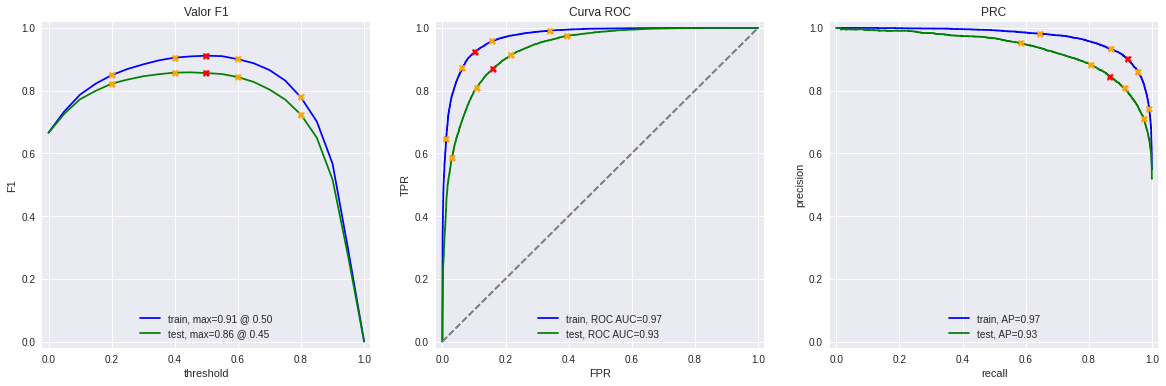

Evaluando svc en el conjunto de datos original:
          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


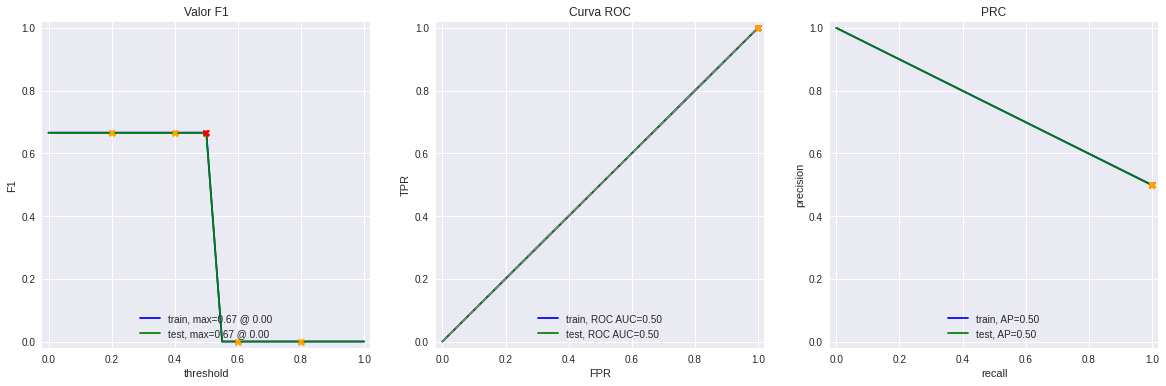

In [ ]:
# Evaluamos y graficamos modelos en el conjunto original
for model_name, model in original_models.items():
    print(f"Evaluando {model_name} en el conjunto de datos original:")
    evaluate_model(model, original_train_set[0], train_target, original_train_set[1], test_target)
    plt.show()

Evaluando lem_logistic en el conjunto de datos lematizado:
          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


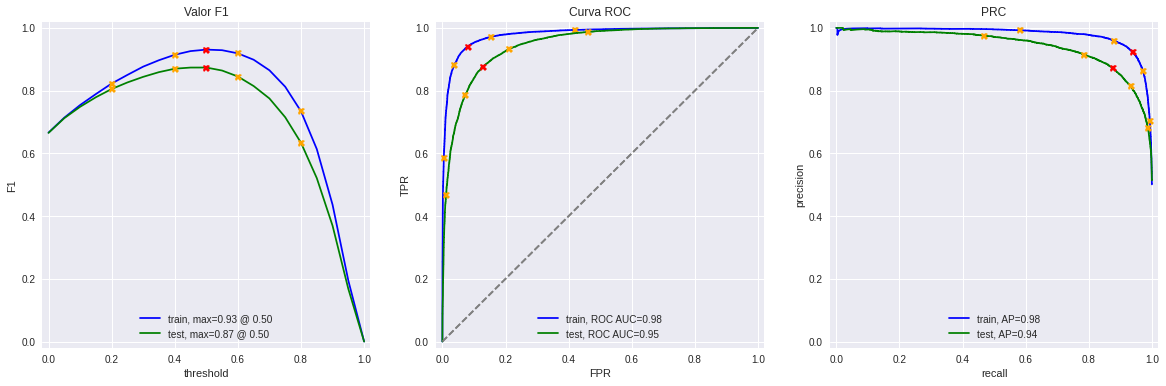

Evaluando lem_lgbm en el conjunto de datos lematizado:
          train  test
Accuracy   0.91  0.85
F1         0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93


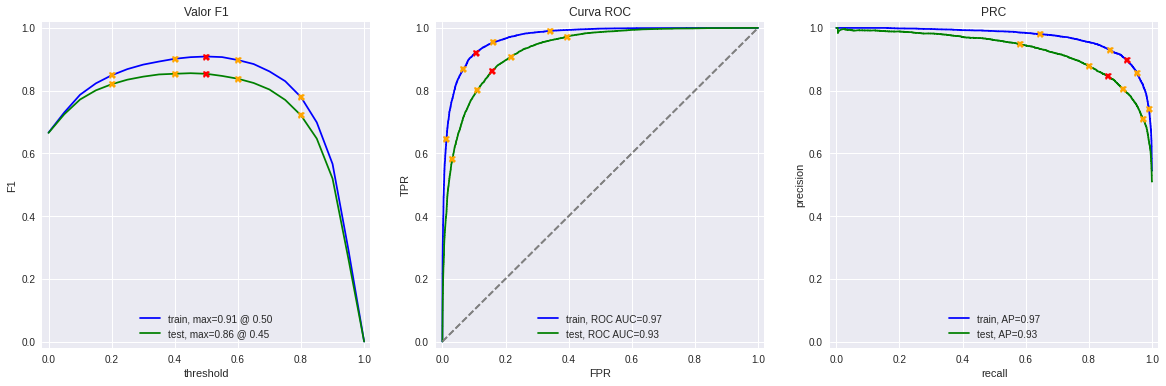

Evaluando lem_svc en el conjunto de datos lematizado:
          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


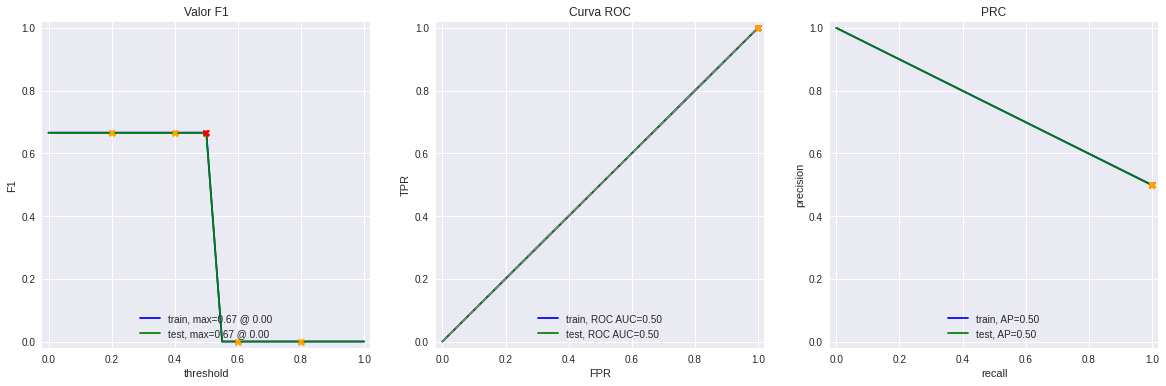

In [ ]:
# Evaluamos y graficamos modelos en el conjunto lematizado
for model_name, model in lemmatized_models.items():
    print(f"Evaluando {model_name} en el conjunto de datos lematizado:")
    evaluate_model(model, lemmatized_train_set[0], train_target, lemmatized_train_set[1], test_target)
    plt.show()

Como una descripción general de los hallazgos, para los modelos **Logistic Regression y LightGBM**:
- Tanto en el conjunto original como en el lematizado los rendimientos respecto a las métricas son bastante altos y casi no difieren.
- Como es de esperar, en los conjuntos de prueba notamos un rendimiento menor, pero que sigue siendo bastante alto.

Por otro lado, respecto al modelo **SVC**:
- Nos indica rendimientos bajos y casi aleatorios en ambos conjuntos de datos. Esto probablemente ocurre debido a que el modelo no está bien afinado.

## Mis reseñas

A continuación probaremos nuestros mejores modelos con nuevas reseñas.

In [ ]:
# Creamos un DataFrame para probar nuestro modelo y normalizamos los reviews
my_reviews = pd.DataFrame([
    'It was such a waste of time and money. Wish I could get my time back',
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.',
    'It really was a cool movie. I loved it.'
], columns=['review'])

# Normalizamos los textos
my_reviews['review_norm'] = my_reviews["review"].apply(lemmatize)
my_reviews['review_norm'] = my_reviews['review'].apply(clean_text)

In [ ]:
# Revisamos los cambios
my_reviews

,review,review_norm
0,It was such a waste of time and money. Wish I ...,it was such a waste of time and money wish i c...
1,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
2,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
3,I was really fascinated with the movie,i was really fascinated with the movie
4,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...
8,It really was a cool movie. I loved it.,it really was a cool movie i loved it


Ahora pondremos a prueba los modelos!

### lr_model - test 1

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob1 = lr_model.predict_proba(tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob1[i]:.2f}:  {review}')

0.02:  it was such a waste of time and money wish i could get my time back
0.09:  i did not simply like it not my kind of movie
0.07:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.17:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.41:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.88:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.95:  it really was a cool movie i loved it


### lgbm_model - test 1

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob1 = lgbm_model.predict_proba(tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob1[i]:.2f}:  {review}')

0.07:  it was such a waste of time and money wish i could get my time back
0.56:  i did not simply like it not my kind of movie
0.33:  well i was bored and felt asleep in the middle of the movie
0.61:  i was really fascinated with the movie
0.43:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.58:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.22:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.69:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.77:  it really was a cool movie i loved it


### lem_lr_model - test 1

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob1 = lem_lr_model.predict_proba(lem_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob1[i]:.2f}:  {review}')

0.02:  it was such a waste of time and money wish i could get my time back
0.19:  i did not simply like it not my kind of movie
0.08:  well i was bored and felt asleep in the middle of the movie
0.51:  i was really fascinated with the movie
0.43:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.44:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.06:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.93:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.57:  it really was a cool movie i loved it


### lem_lgbm_model - test 1

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob1 = lem_lgbm_model.predict_proba(lem_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob1[i]:.2f}:  {review}')

0.09:  it was such a waste of time and money wish i could get my time back
0.60:  i did not simply like it not my kind of movie
0.31:  well i was bored and felt asleep in the middle of the movie
0.62:  i was really fascinated with the movie
0.62:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.63:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.28:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.80:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.62:  it really was a cool movie i loved it


Los modelos funcionan bien por lo general! Tienden a equivocarse una o dos veces de nueve intentos!

**Para tener resultados más concretos llevaremos a cabo este experimento con .predict en lugar de .predict_proba**.

Estableceremos un umbral de 0.5.

### lr_model - test 2

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred1 = (lr_model.predict(tf_idf.transform(texts)) > 0.5).astype(int)

for i, review in enumerate(texts.str.slice(0, 100)):
    sentiment = "Positive" if my_reviews_pred1[i] == 1 else "Negative"
    print(f'{sentiment}: {review}')

Negative: it was such a waste of time and money wish i could get my time back
Negative: i did not simply like it not my kind of movie
Negative: well i was bored and felt asleep in the middle of the movie
Positive: i was really fascinated with the movie
Negative: even the actors looked really old and disinterested and they got paid to be in the movie what a soul
Negative: the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
Negative: what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
Positive: launching on netflix was a brave move i really appreciate being able to binge on episode after episo
Positive: it really was a cool movie i loved it


8 predicciones acertadas de 9!

### lgbm_model - test 2

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred1 = (lgbm_model.predict(tf_idf.transform(texts)) > 0.5).astype(int)

for i, review in enumerate(texts.str.slice(0, 100)):
    sentiment = "Positive" if my_reviews_pred1[i] == 1 else "Negative"
    print(f'{sentiment}: {review}')

Negative: it was such a waste of time and money wish i could get my time back
Positive: i did not simply like it not my kind of movie
Negative: well i was bored and felt asleep in the middle of the movie
Positive: i was really fascinated with the movie
Negative: even the actors looked really old and disinterested and they got paid to be in the movie what a soul
Positive: the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
Negative: what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
Positive: launching on netflix was a brave move i really appreciate being able to binge on episode after episo
Positive: it really was a cool movie i loved it


De nuevo, 8 aciertos de 9!

### lem_lr_model - test 2

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred1 = (lem_lr_model.predict(lem_tf_idf.transform(texts)) > 0.5).astype(int)

for i, review in enumerate(texts.str.slice(0, 100)):
    sentiment = "Positive" if my_reviews_pred1[i] == 1 else "Negative"
    print(f'{sentiment}: {review}')

Negative: it was such a waste of time and money wish i could get my time back
Negative: i did not simply like it not my kind of movie
Negative: well i was bored and felt asleep in the middle of the movie
Positive: i was really fascinated with the movie
Negative: even the actors looked really old and disinterested and they got paid to be in the movie what a soul
Negative: the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
Negative: what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
Positive: launching on netflix was a brave move i really appreciate being able to binge on episode after episo
Positive: it really was a cool movie i loved it


Y otra vez, 8/9!

### lem_lgbm_model - test 2

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred1 = (lem_lgbm_model.predict(lem_tf_idf.transform(texts)) > 0.5).astype(int)

for i, review in enumerate(texts.str.slice(0, 100)):
    sentiment = "Positive" if my_reviews_pred1[i] == 1 else "Negative"
    print(f'{sentiment}: {review}')

Negative: it was such a waste of time and money wish i could get my time back
Positive: i did not simply like it not my kind of movie
Negative: well i was bored and felt asleep in the middle of the movie
Positive: i was really fascinated with the movie
Positive: even the actors looked really old and disinterested and they got paid to be in the movie what a soul
Positive: the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
Negative: what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
Positive: launching on netflix was a brave move i really appreciate being able to binge on episode after episo
Positive: it really was a cool movie i loved it


Esta vez 7 aciertos de 9.

Los cuatro modelos han mostrado un gran rendimiento con estos nuevos reviews.

## Conclusiones

- 1. Primero cargamos los datos, todo estaba en orden a excepción de dos valores nulos que descartamos.


- 2. Al llevar a cabo el EDA vimos cómo aumentó la producción de películas a través del tiempo y, así mismo, el número de reviews.


- 3. En cuanto al balance de clases, encontramos valores bastante equilibrados (23715 y 23614).


- 4. Establecimos una función para calcular el rendimiento de nuestros modelos con las métricas: 'Accuracy', 'F1', 'APS' y 'ROC AUC'.


- 5. Luego vectorizamos, lematizamos y normalizamos los datos, creando dos conjuntos; uno vectorizado y otro vectorizado y lematizado, con el fin de hacer pruebas con los datos en distintas condiciones.


- 6. A continuación entrenamos los modelos lr_model, lgbm_model y svc_model con los datos vectorizados. Además entrenamos otros tres modelos lem_lr_model, lem_lgbm_model y lem_svc_model con los datos vectorizados y lematizados.


- 7. En cuanto al rendimiento, descartamos a los modelos SVC, debido a su bajo rendimiento. Los demás modelos tuvieron rendimientos excelentes, con puntajes entre 85 y 95 en los conjuntos de prueba, de acuerdo a las métricas seleccionadas! Por otra parte, tomó al rededor de 2 horas entrenar a todos los modelos.


- 8. Por otro lado, para mejorar el rendimiento de los modelos SVC se podría probar lo siguiente: experimentar con distintos hiperparámetros, tratar de reducir la dimensión de los datos con alguna técnica para seleccionar solo las variables más importantes y experimentar con distintas configuraciones del vectorizador. Esto también podría aplicarse para intentar mejorar el rendimiento de los otros modelos, aunque ya poseen un desempeño bastante alto.


- 9. Al poner a prueba a los mejores modelos, estos acertaron en 8 de cada 9 textos, clasificándolos correctamente entre reviews negativos y positivos!

<div class="alert alert-block alert-success">
    
# Comentarios generales
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Todo corregido. Has aprobado un nuevo proyecto. ¡Felicitaciones!
</div>

# Lista de comprobación

- [x]  Abriste el notebook
- [ ]  Cargaste y preprocesaste los datos de texto para su vectorización
- [ ]  Transformaste los datos de texto en vectores
- [ ]  Entrenaste y probaste los modelos
- [ ]  Se alcanzó el umbral de la métrica
- [ ]  Colocaste todas las celdas de código en el orden de su ejecución
- [ ]  Puedes ejecutar sin errores todas las celdas de código
- [ ]  Hay conclusiones